# Headway analysis and figure making

In [1]:
import time as systime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import binned_statistic_2d, ks_2samp, binned_statistic, gaussian_kde
plt.rcParams["font.family"] = 'Arial'
plt.style.use('default')
font = {'family' : 'Arial', 'size'   : 8}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'cm'
from tqdm import tqdm

import visual_utils as vis

figure_path = r'C:/SURFdrive/PhD progress/PhDResearch/3_AVCF/PartC/Figures/'

## 1 Datasets

In [27]:
def read_data(cfpair, dataset):
    data = pd.read_hdf(r'U:/Vehicle Coordination Yiru/InputData/'+dataset+'/CFdata/'+cfpair+'.h5', key='data').reset_index(drop=True)
    regimes = pd.read_hdf(r'U:/Vehicle Coordination Yiru/OutputData/CFAV/headway/CF regime/'+dataset+'/regimes/regimes_all_'+cfpair+'.h5', key='regimes')
    data = data.merge(regimes, on=['case_id','time'], how='left')

    # correct negative speeds due to filtering
    data.loc[(data['v_follower']<0),'v_follower'] = 0.
    data.loc[(data['v_leader']<0),'v_leader'] = 0.

    data['dhw'] = data['x_leader'] - data['x_follower']
    data['thw'] = data['dhw']/data['v_follower']
    data.loc[np.isinf(data['thw']),'thw'] = np.nan
    
    return data   

Waymo_AH = read_data('AH', 'Waymo')
Waymo_HA = read_data('HA', 'Waymo')
Waymo_HH = read_data('HH', 'Waymo')
Lyft_AH = read_data('AH', 'Lyft')
Lyft_HA = read_data('HA', 'Lyft')
Lyft_HH = read_data('HH', 'Lyft')

### 1.1 Dataset selection

In [28]:
print('Lyft:')
print('AH train min duration:', Lyft_AH.groupby('case_id').time.count().min()/10)
print('HA train min duration:', Lyft_HA.groupby('case_id').time.count().min()/10)
print('HH train min duration:', Lyft_HH.groupby('case_id').time.count().min()/10)
print('Waymo:')
print('AH train min duration:', Waymo_AH.groupby('case_id').time.count().min()/10)
print('HA train min duration:', Waymo_HA.groupby('case_id').time.count().min()/10)
print('HH train min duration:', Waymo_HH.groupby('case_id').time.count().min()/10)

Lyft:
AH train min duration: 14.9
HA train min duration: 14.9
HH train min duration: 14.2
Waymo:
AH train min duration: 13.8
HA train min duration: 10.0
HH train min duration: 7.8


In [29]:
# Waymo
dataset_description = pd.DataFrame({'dataset':['Waymo_AH','Waymo_HA','Waymo_HH']})
dataset_description = dataset_description.set_index('dataset')
for data, setname in zip([Waymo_AH, Waymo_HA, Waymo_HH],['Waymo_AH','Waymo_HA','Waymo_HH']):
    test = data.groupby('case_id').agg({'v_follower':['min','max'],'v_leader':['min','max'], 'time':'max'})
    dataset_description.loc[setname,'num cases'] = len(test)
    # valid cases should have diverse car-following states
    valid_cases = test[(test['v_follower']['min']<0.1)&
                       (test['v_leader']['min']<0.1)&
                       (test['v_follower']['max']>=10)]
    dataset_description.loc[setname,'num valid cases'] = len(valid_cases)
    dataset_description.loc[setname,'average duration of valid cases'] = valid_cases['time']['max'].mean()

dataset_description.round(2)

,num cases,num valid cases,average duration of valid cases
dataset,,,
Waymo_AH,210.0,27.0,19.75
Waymo_HA,286.0,33.0,19.76
Waymo_HH,1117.0,135.0,19.54


In [30]:
# Lyft
dataset_description = pd.DataFrame({'dataset':['Lyft_AH','Lyft_HA','Lyft_HH']})
dataset_description = dataset_description.set_index('dataset')
for data, setname in zip([Lyft_AH, Lyft_HA, Lyft_HH],['Lyft_AH','Lyft_HA','Lyft_HH']):
    test = data.groupby('case_id').agg({'v_follower':['min','max'],'v_leader':['min','max'], 'time':'max'})
    dataset_description.loc[setname,'num cases'] = len(test)
    # valid cases should have diverse car-following states
    valid_cases = test[(test['v_follower']['min']<0.1)&
                       (test['v_leader']['min']<0.1)&
                       (test['v_follower']['max']>=10)]
    dataset_description.loc[setname,'num valid cases'] = len(valid_cases)
    dataset_description.loc[setname,'average max. speed in valid cases'] = valid_cases['time']['max'].mean()

dataset_description.round(2)

,num cases,num valid cases,average max. speed in valid cases
dataset,,,
Lyft_AH,9172.0,1886.0,24.86
Lyft_HA,29449.0,5542.0,38.92
Lyft_HH,42892.0,9243.0,21.65


### 1.2 Lyft overview

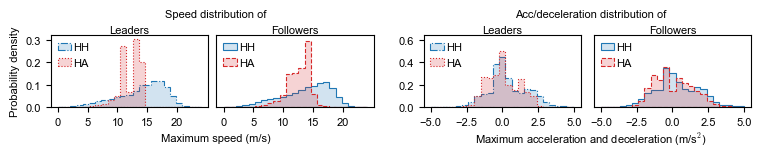

In [6]:
fig, axes = vis.compare_HH_HA(Lyft_HH, Lyft_HA)

In [4]:
fig.savefig(figure_path+'HH_HA_va.pdf', bbox_inches='tight', dpi=600)

### 1.3 Sensor error

#### 1.3.1 Length distribution
Unsure the influence of sensor error.

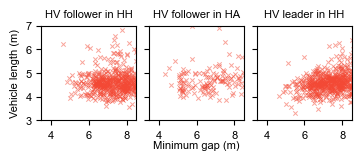

In [37]:
fig, axes = vis.length_dist(Waymo_HH,
                            Waymo_HA, 'Waymo')

In [38]:
fig.savefig(figure_path+'length_dist_waymo.pdf', bbox_inches='tight', dpi=600)

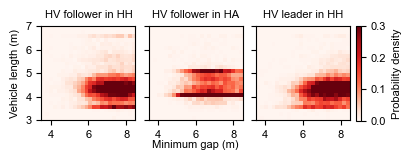

In [34]:
fig, axes = vis.length_dist(Lyft_HH,
                            Lyft_HA, 'Lyft')

In [7]:
fig.savefig(figure_path+'length_dist_lyft.pdf', bbox_inches='tight', dpi=600)

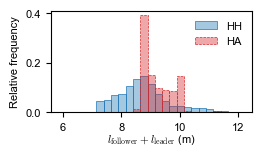

In [9]:
fig, axes = vis.length_impact(Lyft_HH[(Lyft_HH['v_leader']<0.1)&(Lyft_HH['v_follower']<0.1)],
                              Lyft_HA[(Lyft_HA['v_leader']<0.1)&(Lyft_HA['v_follower']<0.1)])

In [10]:
fig.savefig(figure_path+'length_impact.pdf', bbox_inches='tight', dpi=600)

In [11]:
cfdata_HH = Lyft_HH[(Lyft_HH['v_leader']<0.1)&(Lyft_HH['v_follower']<0.1)]
cfdata_HH = cfdata_HH.groupby('case_id')[['l_follower','l_leader']].first()
cfdata_HA = Lyft_HA[(Lyft_HA['v_leader']<0.1)&(Lyft_HA['v_follower']<0.1)]
cfdata_HA = cfdata_HA.groupby('case_id')[['l_follower','l_leader']].first()
length_HH = (cfdata_HH.l_follower + cfdata_HH.l_leader).mean()
length_HA = (cfdata_HA.l_follower + cfdata_HA.l_leader).mean()
print('Lyft impacts on gap', length_HA, length_HH, length_HA-length_HH)

cfdata_HH = Waymo_HH[(Waymo_HH['v_leader']<0.1)&(Waymo_HH['v_follower']<0.1)]
cfdata_HH = cfdata_HH.groupby('case_id')[['l_follower','l_leader']].first()
cfdata_HA = Waymo_HA[(Waymo_HA['v_leader']<0.1)&(Waymo_HA['v_follower']<0.1)]
cfdata_HA = cfdata_HA.groupby('case_id')[['l_follower','l_leader']].first()
length_HH = (cfdata_HH.l_follower + cfdata_HH.l_leader).mean()
length_HA = (cfdata_HA.l_follower + cfdata_HA.l_leader).mean()
print('Waymo impacts on gap', length_HA, length_HH, length_HA-length_HH)

Lyft impacts on gap 9.24623283104983 8.79207040003726 0.4541624310125716
Waymo impacts on gap 10.31512 9.64032258064516 0.6747974193548405


### 1.4 Min. distance and time headway (baseline)

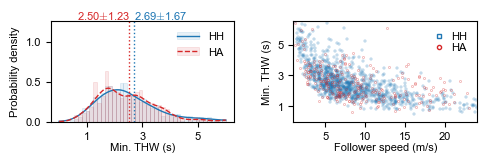

In [12]:
fig, axes = vis.headway_dist(Waymo_HH,Waymo_HA)

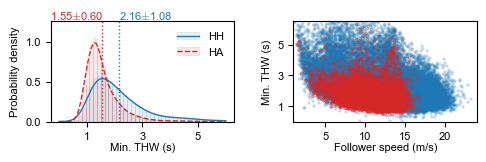

In [16]:
fig, axes = vis.headway_dist(Lyft_HH,Lyft_HA)

In [14]:
fig.savefig(figure_path+'headway_dist_original.pdf', bbox_inches='tight', dpi=600)

## 2 CF regime

In [15]:
def assign_regime_id(cfdata):
    cfdata = cfdata.copy()
    regime_indices = cfdata[['case_id','time','regime']].sort_values(by=['case_id','time']).reset_index().set_index('case_id')
    cfdata['regime_id'] = np.zeros(len(cfdata)).astype(int)
    cfdata['regime_duration'] = np.zeros(len(cfdata))
    regime_id = 1
    for caseid in tqdm(regime_indices.index.unique()):
        cfdf = regime_indices.loc[caseid]
        end_list = np.where(cfdf.iloc[1:]['regime'].values!=cfdf.iloc[:-1]['regime'].values)[0]
        start_list = end_list + 1
        start_list = np.append(0,start_list)
        end_list = np.append(end_list,len(cfdf)-1)
        end_list = end_list + 1
        for start,end in zip(start_list,end_list):
            cfdata.loc[cfdf['index'].values[start:end],'regime_duration'] = (end-start)*0.1
            if end-start<5:
                cfdata.loc[cfdf['index'].values[start:end],'regime_id'] = 0
            else:
                cfdata.loc[cfdf['index'].values[start:end],'regime_id'] = regime_id
                regime_id += 1
    return cfdata

In [20]:
Lyft_HA = assign_regime_id(Lyft_HA)
# Lyft_HH = assign_regime_id(Lyft_HH)

100%|██████████| 7638/7638 [00:59<00:00, 128.83it/s]


### 2.1 Regime distribution

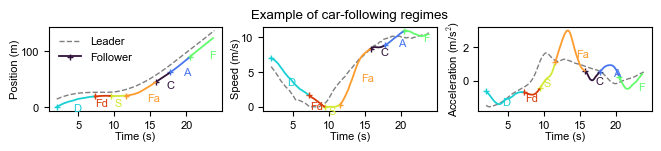

In [21]:
fig, axes = vis.regime_example(Lyft_HA)

In [22]:
# fig.savefig(figure_path+'regime_example.pdf', bbox_inches='tight', dpi=600)

In [13]:
regime_list_HA = pd.read_csv(r'U:/Vehicle Coordination Yiru/OutputData/CFAV/headway/CF regime/Lyft/regimes/regimes_list_HA.csv')
regime_list_HH = pd.read_csv(r'U:/Vehicle Coordination Yiru/OutputData/CFAV/headway/CF regime/Lyft/regimes/regimes_list_HH.csv')

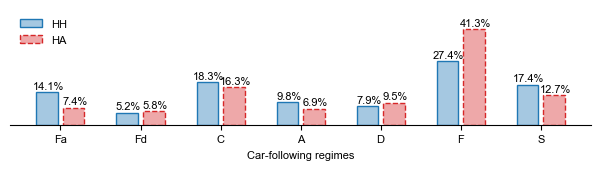

In [14]:
fig, ax = vis.regime_proportion(regime_list_HA, regime_list_HH)

In [18]:
fig.savefig(figure_path+'regime_proportion.pdf', bbox_inches='tight', dpi=600)

In [19]:
# thw HH
thw_HH = Lyft_HH.loc[Lyft_HH.groupby('case_id')['thw'].idxmin()].groupby('regime').agg({'time':'count','thw':'mean'})
thw_HH['time'] = thw_HH['time']/thw_HH['time'].sum()*100
thw_HH.loc[['Fa','C','Fd','D','A','F']].T.round(2)

regime,Fa,C,Fd,D,A,F
time,8.99,11.01,7.42,23.22,11.09,38.27
thw,3.12,2.91,2.71,1.89,2.18,1.79


In [20]:
# thw HA
thw_HA = Lyft_HA.loc[Lyft_HA.groupby('case_id')['thw'].idxmin()].groupby('regime').agg({'time':'count','thw':'mean'})
thw_HA['time'] = thw_HA['time']/thw_HA['time'].sum()*100
thw_HA.loc[['Fa','C','Fd','D','A','F']].T.round(2)

regime,Fa,C,Fd,D,A,F
time,2.37,6.83,8.40,39.7,1.29,41.41
thw,2.06,2.10,2.06,1.4,1.77,1.46


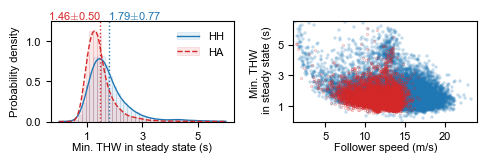

In [22]:
fig, axes = vis.headway_dist_regime(Lyft_HH, Lyft_HA)

In [22]:
fig.savefig(figure_path+'headway_dist_regime.pdf', bbox_inches='tight', dpi=600)

## 3 Driver variability effect

In [4]:
def read_data_idm(cfpair,incul_data=False,data_path='../Data/OutputData/Variability/'):
    parameters = pd.read_csv(data_path+'idm/parameters_idm_Lyft_'+cfpair+'.csv', index_col=0)
    parameters = parameters.dropna()

    loss = pd.read_csv(data_path+'idm/loss_idm_Lyft_'+cfpair+'.csv', index_col=0)
    loss = loss.loc[parameters.index]

    if incul_data:
        data = pd.read_hdf(data_path+'cfdata_idm_Lyft_'+cfpair+'.h5', key='data')
        data['dhw'] = data['x_leader'] - data['x_follower'] - data['l_follower']/2 + data['l_leader']/2
        data['thw'] = data['dhw'] / data['v_follower']

    return (data, parameters, loss) if incul_data else (parameters, loss)

{Fa, A, D, F} | {S, A, D, F}

Waymo HA 1 4.95, Waymo HH 21 5.00

Lyft HA 1701 4.70, Lyft HH 1498 4.43

Longest duration 983

HH 1498 4.43, HA 1559 4.66

In [5]:
data_HA, idm_HA, loss_HA = read_data_idm('HA',incul_data=True)
data_HH, idm_HH, loss_HH = read_data_idm('HH',incul_data=True)

# idm_HA, loss_HA = read_data_idm('HA',incul_data=False)
# idm_HH, loss_HH = read_data_idm('HH',incul_data=False)

In [27]:
# only non-zero compared
loss_HH.dropna().agg(['count','mean','std']).round(2)

,MAE_a,MAE_v,MAE_s,RMSE_a,RMSE_v,RMSE_s
count,1498.00,1498.00,1498.00,1498.00,1498.00,1498.00
mean,0.42,0.60,2.47,0.58,0.75,3.14
std,0.16,0.31,2.36,0.26,0.36,2.64


In [28]:
# only non-zero compared
loss_HA.dropna().agg(['count','mean','std']).round(2)

,MAE_a,MAE_v,MAE_s,RMSE_a,RMSE_v,RMSE_s
count,1559.00,1559.00,1559.00,1559.00,1559.00,1559.00
mean,0.35,0.55,2.40,0.47,0.68,2.97
std,0.11,0.38,4.34,0.20,0.41,4.90


### 3.1 IDM parameter comparison

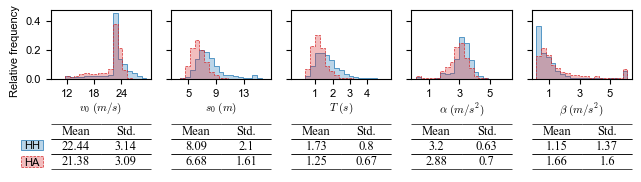

In [56]:
fig, axes = vis.idm_parameters(idm_HH,idm_HA)

In [57]:
fig.savefig(figure_path+'idm_parameters.pdf', dpi=600, bbox_inches='tight')

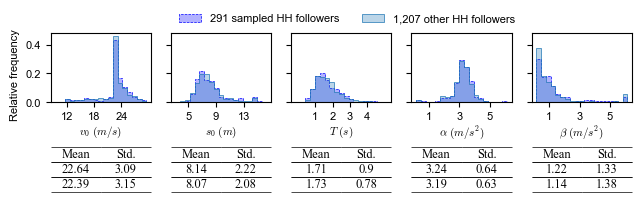

In [64]:
idm_HH_lowerVar = idm_HH.loc[np.random.RandomState(100).choice(idm_HH.index, size=291, replace=False)]
idm_HH_higherVar = idm_HH.loc[~idm_HH.index.isin(idm_HH_lowerVar.index)]
fig, axes = vis.idm_sampling(idm_HH_lowerVar, idm_HH_higherVar)

In [65]:
fig.savefig(figure_path+'idm_sampling.pdf', dpi=600, bbox_inches='tight')

### 3.2 Cross following

In [8]:
def read_data_crossfollow(cfpair):
    data = pd.read_hdf(r'U:/Vehicle Coordination Yiru/OutputData/CFAV/headway/IDM/crossfollow/crossfollow_Lyft_'+cfpair+'.h5', key='data')
    regimes = pd.read_hdf(r'U:/Vehicle Coordination Yiru/OutputData/CFAV/headway/CF regime/Simulated Lyft/regimes/regimes_all_'+cfpair+'.h5', key='regimes')
    data = data.merge(regimes, on=['case_id','time'], how='left')
    return data

#### 3.2.1 Leader variety

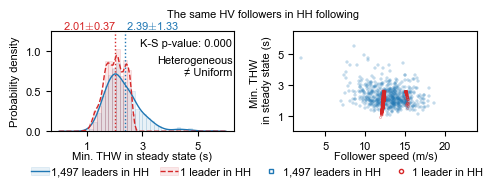

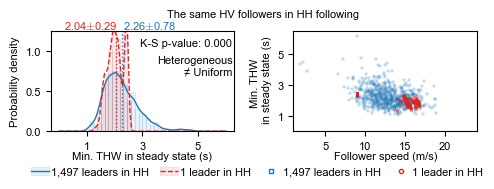

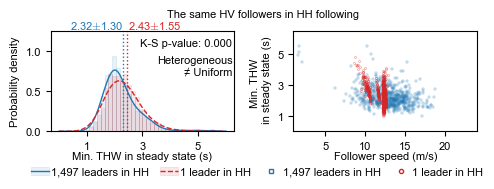

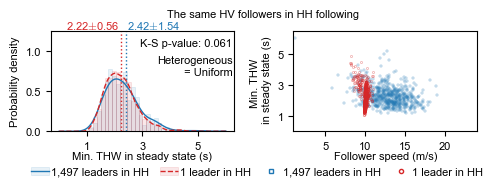

In [17]:
for count in [0,2,3,4]:
    fHH_lHHhigherVar = read_data_crossfollow('fHH_lHHhigherVar_'+str(count))
    fHH_lHHlowerVar = read_data_crossfollow('fHH_lHHlowerVar_'+str(count))
    fig, axes = vis.headway_leader_variability(fHH_lHHhigherVar, fHH_lHHlowerVar, count)
    fig.savefig(figure_path+'headway_leader_variability_'+str(count)+'.pdf', bbox_inches='tight', dpi=600)

#### 3.2.2 Follower variety

In [68]:
fHHhigherVar_lHH = read_data_crossfollow('fHHhigherVar_lHH')
fHHlowerVar_lHH = read_data_crossfollow('fHHlowerVar_lHH')

fHHhigherVar_lHH['case_id'].nunique(), fHHlowerVar_lHH['case_id'].nunique()

(3618, 3765)

In [4]:
# fig, axes = vis.headway_follower_variability(fHHhigherVar_lHH, fHHlowerVar_lHH)

In [70]:
# fig.savefig(figure_path+'headway_follower_variability.pdf', bbox_inches='tight', dpi=600)

## 4 AV dynamics

traindata, HH case num: 15111 HA case num: 13813

traindata, HH subcase num: 30246 HA subcase num: 30257

valdata, HH case num: 15112 HA case num: 13814

valdata, HH subcase num: 30241 HA subcase num: 30199

In [18]:
inputdata_path = r'U:/Vehicle Coordination Yiru/OutputData/CFAV/headway/AV leader/data/'
outputdata_path = r'U:/Vehicle Coordination Yiru/OutputData/CFAV/headway/AV leader/results_lstm/'

### 4.1 Classification evaluation

In [22]:
confusion_matrices = pd.read_csv(outputdata_path+'confusion_matrices.csv')
loss_records = pd.read_csv(outputdata_path+'loss_records.csv')

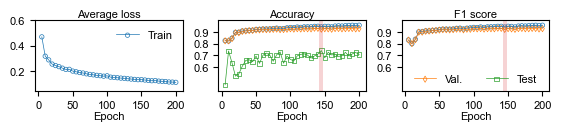

In [73]:
fig, axes = vis.evaluate_classifier(confusion_matrices[confusion_matrices['num_epoches']<205].copy(),loss_records)

In [74]:
fig.savefig(figure_path+'classifier_evaluation.pdf',dpi=600, bbox_inches='tight')

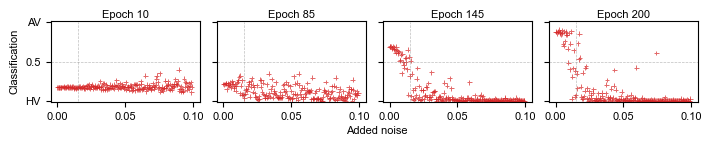

In [23]:
zero_tests = []
for epoch in [10,85,145,200]:
    zero_test = pd.read_csv(outputdata_path+'zero_test'+str(epoch)+'.csv')
    zero_tests.append(zero_test)

fig, axes = vis.scatter_zero_test(zero_tests, [10,85,145,200])

In [76]:
fig.savefig(figure_path+'static_state_test.pdf',dpi=600, bbox_inches='tight')

### 4.2 Classification results

In [19]:
# 1: AV leader, 0: HV leader
def read_classified_data(setname):
    data_HAandHH = pd.read_hdf(inputdata_path+'data_'+setname+'_HAandHH.h5', key='data')
    label_HAandHH = pd.read_hdf(inputdata_path+'label_'+setname+'_HAandHH.h5', key='label')
    pred_HAandHH = pd.read_csv(outputdata_path+'prediction_'+setname+'.csv')

    label_HAandHH['prediction'] = pred_HAandHH.set_index('new_id').loc[label_HAandHH['new_id'].values]['prediction'].values
    pred_HAandHH = data_HAandHH[['label','new_id','case_id','subcase','time']].copy()
    pred_HAandHH['pred'] = label_HAandHH.set_index(['new_id']).loc[data_HAandHH['new_id'].values]['prediction'].values

    data_HAandHH = data_HAandHH.drop_duplicates(subset=['case_id','time']).drop(columns=['subcase'])
    aggregation = pred_HAandHH.groupby(['label','case_id','time'])['pred'].mean().reset_index().set_index(['label','case_id','time'])
    data_HAandHH['pred_time'] = aggregation.reindex(pd.MultiIndex.from_frame(data_HAandHH[['label','case_id','time']])).values
    aggregation = pred_HAandHH.groupby(['label','case_id'])['pred'].mean().reset_index().set_index(['label','case_id'])
    data_HAandHH['pred_case'] = aggregation.reindex(pd.MultiIndex.from_frame(data_HAandHH[['label','case_id']])).values

    HA = data_HAandHH[(data_HAandHH['label']>0.5)].copy()
    HA[['v_leader','a_leader','v_follower','dhw','thw']] = Lyft_HA.set_index(['case_id','time']).reindex(pd.MultiIndex.from_frame(HA[['case_id','time']]))[['v_leader','a_leader','v_follower','dhw','thw']].values
    HA['regime'] = Lyft_HA.set_index(['case_id','time']).reindex(pd.MultiIndex.from_frame(HA[['case_id','time']]))['regime'].values
    HH = data_HAandHH[(data_HAandHH['label']<0.5)].copy()
    HH[['v_leader','a_leader','v_follower','dhw','thw']] = Lyft_HH.set_index(['case_id','time']).reindex(pd.MultiIndex.from_frame(HH[['case_id','time']]))[['v_leader','a_leader','v_follower','dhw','thw']].values
    HH['regime'] = Lyft_HH.set_index(['case_id','time']).reindex(pd.MultiIndex.from_frame(HH[['case_id','time']]))['regime'].values

    return HA, HH

In [20]:
# train_HA, train_HH = read_classified_data('train')
val_HA, val_HH = read_classified_data('val')

In [21]:
print('In validation set:')
print('Num of HA leaders classified as HV', val_HA[val_HA['pred_case']<0.5]['case_id'].nunique())
print('Num of HA leaders classified as AV', val_HA[val_HA['pred_case']>0.5]['case_id'].nunique())
print('Num of HH leaders classified as HV', val_HH[val_HH['pred_case']<0.5]['case_id'].nunique())
print('Num of HH leaders classified as AV', val_HH[val_HH['pred_case']>0.5]['case_id'].nunique())

In validation set:
Num of HA leaders classified as HV 1104
Num of HA leaders classified as AV 12710
Num of HH leaders classified as HV 10569
Num of HH leaders classified as AV 457


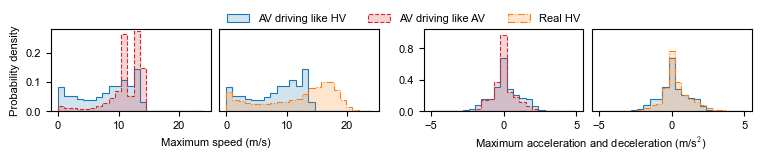

In [80]:
fig, axes = vis.compare_leader(val_HA[val_HA['pred_case']<=0.5], val_HA[val_HA['pred_case']>0.5], Lyft_HH)

In [81]:
fig.savefig(figure_path+'compare_leader.pdf',dpi=600, bbox_inches='tight')

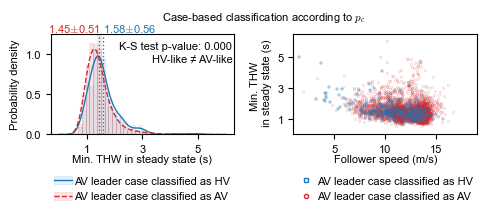

In [22]:
fig, axes = vis.headway_dist_dynamics(val_HA, 'pred_case')

In [23]:
fig.savefig(figure_path+'headway_dist_dynamics_case.pdf', dpi=600, bbox_inches='tight')

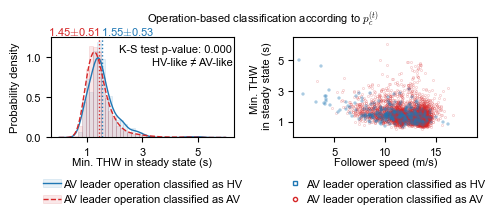

In [24]:
fig, axes = vis.headway_dist_dynamics(val_HA, 'pred_time')

In [25]:
fig.savefig(figure_path+'headway_dist_dynamics_time.pdf', dpi=600, bbox_inches='tight')

## 5 Discussion: THW to DHW

In [6]:
output_path = r'U:/Vehicle Coordination Yiru/OutputData/CFAV/headway/CF regime/'
regime_list_HH = pd.read_csv(output_path+'Lyft/regimes/regimes_list_HH.csv', index_col=0)
regime_list_HA = pd.read_csv(output_path+'Lyft/regimes/regimes_list_HA.csv', index_col=0)

In [7]:
def select_deceleration(cfdata, regime_list):
    cfdata = cfdata.sort_values(by=['case_id','time'])
    selected_regimes = []
    regime_id = 0
    for caseid in tqdm(regime_list[np.all(regime_list[['S','D']]>0.5, axis=1)|np.all(regime_list[['S','Fd']]>0.5, axis=1)].index):
        cfdf = cfdata.loc[caseid]
        end_list = np.where((cfdf.iloc[1:]['regime']=='S')&(cfdf.iloc[:-1]['regime'].isin(['D','Fd'])))[0]
        for end in end_list:
            if len(cfdf.iloc[:end])>=9 and np.all(cfdf.iloc[end-9:end]['regime']==cfdf.iloc[end]['regime']):
                start_list = np.where((cfdf['regime']==cfdf.iloc[end]['regime'])&(cfdf['time']<cfdf.iloc[end]['time']))[0]
                if np.all(np.round(np.diff(start_list))<=1.5):
                    start = start_list[0]
                else:
                    start = start_list[np.where(np.round(np.diff(start_list))>1.5)[0][-1]+1]
                cf_regime = cfdf.iloc[start:end+1].copy()
                cf_regime['regime_id'] = regime_id
                regime_id += 1
                selected_regimes.append(cf_regime)
    selected_regimes = pd.concat(selected_regimes)
    selected_regimes = selected_regimes[selected_regimes.groupby('regime_id')['a_follower'].transform('max')<0]
    selected_regimes = selected_regimes.sort_values(by=['regime_id','time'])
    selected_regimes = selected_regimes[(selected_regimes.groupby('regime_id')['dhw'].transform('first')-selected_regimes.groupby('regime_id')['dhw'].transform('last'))>0]

    first = selected_regimes.groupby('regime_id')[['a_follower','a_leader','dhw','thw']].first()
    last = selected_regimes.groupby('regime_id')[['a_follower','a_leader','dhw','thw']].last()

    selected_regimes['time_start'] = selected_regimes.groupby('regime_id')['time'].transform('first')
    selected_regimes['time'] = selected_regimes['time'] - selected_regimes['time_start']
    selected_regimes['time_end'] = selected_regimes.groupby('regime_id')['time'].transform('last')
    selected_regimes['order'] = selected_regimes.groupby('regime_id')['dhw'].transform('first')
    selected_regimes = selected_regimes.sort_values(by=['time_end','order','time'], ascending=[False,True,True])
    selected_regimes = selected_regimes.set_index('regime_id')
    timestarts = np.linspace(0,10,len(selected_regimes.index.unique()))
    for regimeid,timestart in zip(selected_regimes.index.unique(),timestarts):
        selected_regimes.loc[regimeid,'time_start'] = timestart
    selected_regimes['time'] = selected_regimes['time'] + selected_regimes['time_start']
    selected_regimes = selected_regimes.reset_index()

    return first, last, selected_regimes

In [130]:
first_HH, last_HH, selected_regimes_HH = select_deceleration(Lyft_HH.set_index('case_id'), regime_list_HH.loc[Lyft_HH['case_id'].unique()])
first_HA, last_HA, selected_regimes_HA = select_deceleration(Lyft_HA.set_index('case_id'), regime_list_HA.loc[Lyft_HA['case_id'].unique()])

100%|██████████| 5515/5515 [00:06<00:00, 810.57it/s] 


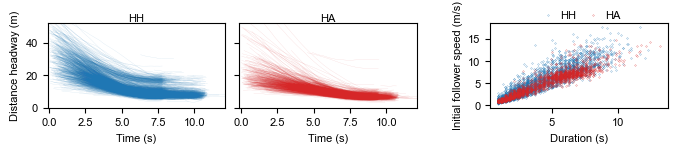

In [162]:
fig, axes = plt.subplots(1,4,figsize=(8.,1.1),gridspec_kw={'width_ratios':[1,1,0.25,1],'wspace':0.1})
axes[2].axis('off')

lines_HA = [line[['time','dhw']].values for _, line in selected_regimes_HA.groupby('regime_id')[['time','dhw']]]
lc_HA = mpl.collections.LineCollection(lines_HA, color='tab:red', linewidth=0.15, alpha=0.25, rasterized=True)
lines_HH = [line[['time','dhw']].values for _, line in selected_regimes_HH.groupby('regime_id')[['time','dhw']]]
lc_HH = mpl.collections.LineCollection(lines_HH, color='tab:blue', linewidth=0.15, alpha=0.25, rasterized=True)

axes[0].add_collection(lc_HH)
axes[1].add_collection(lc_HA)

for ax in [axes[0],axes[1]]:
    ax.set_xlim([-0.1,12.1])
    ax.set_ylim([0,52])

axes[0].set_title('HH', fontsize=8, pad=0)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Distance headway (m)')
axes[1].set_title('HA', fontsize=8, pad=0)
axes[1].set_xlabel('Time (s)')
axes[1].set_yticklabels([])

group = selected_regimes_HH.groupby('regime_id')
axes[3].plot(group['time_end'].first(), group['v_follower'].first(), 'o', ms=1., fillstyle='none', mew=0.2, c='tab:blue', label='HH', rasterized=True)
group = selected_regimes_HA.groupby('regime_id')
axes[3].plot(group['time_end'].first(), group['v_follower'].first(), 'o', ms=1., fillstyle='none', mew=0.2, c='tab:red', label='HA', rasterized=True)
axes[3].set_xlabel('Duration (s)')
axes[3].set_ylabel('Initial follower speed (m/s)')
axes[3].set_yticks([0,5,10,15])
axes[3].legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, 0.95), fontsize=8, handletextpad=0.1, borderpad=0.1, labelspacing=0.1, ncol=2, columnspacing=0.5)

In [163]:
fig.savefig(figure_path+'reductionDHW.pdf', dpi=600, bbox_inches='tight')

# Appendix FD

In [65]:
def draw_FD(cfdata): # Xiaopeng Li https://doi.org/10.1016/j.trb.2021.06.011
    k = []
    q = []
    for regime in ['C','A','D','F']:
        steady_cf = cfdata[cfdata['regime']==regime]
        steady_cf = steady_cf[steady_cf.groupby('case_id').time.transform('count')>30].set_index('case_id')
        # steady_cf['dhw'] = steady_cf['x_leader'] - steady_cf['x_follower']
        steady_cf['dhw'] = steady_cf['dhw']/1000 # convert to km
        steady_cf['x_follower'] = steady_cf['x_follower']/1000 # convert to km
        for caseid in tqdm(steady_cf.index.unique()):
            steady_cf_case = steady_cf.loc[caseid]
            for splited_case in np.split(steady_cf_case, np.where(np.round(np.diff(steady_cf_case.time.values),1)!=0.1)[0]+1):
                if len(splited_case) < 10 or splited_case['v_follower'].mean()>8:
                    continue
                else:
                    splited_case['time'] = splited_case['time']/3600 # convert to hour
                    area = np.trapz(splited_case['dhw'].values, splited_case['time'].values)
                    k.append((splited_case['time'].max()-splited_case['time'].min())/area)
                    q.append((splited_case['x_follower'].iloc[-1]-splited_case['x_follower'].iloc[0])/area)
    return np.array(k), np.array(q)

100%|██████████| 4057/4057 [00:05<00:00, 706.27it/s]


(-10.0, 4000.0)

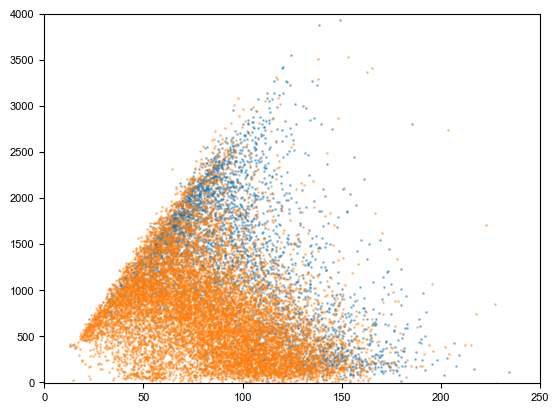

In [66]:
k, q = draw_FD(Lyft_HA)
plt.scatter(k, q, s=1, alpha=0.4)
k, q = draw_FD(Lyft_HH)
plt.scatter(k, q, s=1, alpha=0.4)
plt.xlim([0,250])
plt.ylim([-10,4000])